In [201]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import caffe
import itertools as it
import pandas
import cv2
import scipy
import subprocess

from os.path import join as pjoin
from math import ceil
from copy import copy
from collections import OrderedDict
from operator import itemgetter, attrgetter
from matplotlib import pyplot
from scipy import ndimage as ndimage

from caffe import layers as L
from caffe import params as P
import tools

from ntb.layer.data import Transformer
from ntb.db import *

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 2
pyplot.rcParams['figure.figsize'] = (10, 6)

In [2]:
db = NTBDB()

In [77]:
class Network(object):
    def __init__(self, definition, weights, labels, transformer):
        self.net = caffe.Net(definition, caffe.TEST, weights=weights)
        self.transformer = transformer
        self.labels = labels
    
    def set_batch(self, batch_size):
        data_layer = self.net.blobs['data']
        shape = self.net.blobs['data'].shape
        shape[0] = batch_size
        data_layer.reshape(*shape)
        print "Set batch_size to", batch_size

    def get_scores(self, indexes, batch_size=256):
        batch_size=min(len(indexes), batch_size)
        indexes = np.asarray(list(indexes))
        self.set_batch(batch_size)

        def predict_batch(batch):
            for i, index in enumerate(batch):
                image = caffe.io.load_image(image_path(db.metadata[index]))
                self.net.blobs['data'].data[...][i] = self.transformer.preprocess(image)
            self.net.forward()

        def get_batch_scores(batch):
            res = []
            for i, index in enumerate(batch):
                row = list()
                row.insert(0, index)
                yield (index,) + tuple(self.net.blobs['score'].data[i])

        batch_num = int(ceil(indexes.size/float(batch_size)))
        scores = []
        print "Going to process", batch_num, "batches"
        for i, batch in enumerate(np.array_split(indexes, batch_num)):
            predict_batch(batch)
            scores.extend(get_batch_scores(batch))
            if i % 50 == 0:
                print "Batch", i, "finised"

        dtype = [(label, 'f4') for label in self.labels]
        dtype.insert(0, ('idx', 'S27'))
        return np.array(scores, dtype=dtype)

In [11]:
def get_curves(labels, scores, ground_truth):
    def get_label_curve(label):
        sorted_images = np.sort(scores, order=[label], axis=0)[['idx']][::-1].copy().view('S27')

        res = []
        predicted_true = 0
        true_positive = 0
        for index in sorted_images:
            predicted_true += 1
            if index in ground_truth[label]:
                true_positive += 1
            p = float(true_positive) / predicted_true
            r = float(true_positive) / len(ground_truth[label])
            res.append((p, r))
        return np.array(res, dtype=[('precision', 'f4'), ('recall', 'f4')])

    return {label: get_label_curve(label) for label in labels}

In [12]:
def get_average_precision(curves):
    recall_range = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    res = {}
    for label, label_curve in curves.iteritems():
        s = 0.0
        for recall in recall_range:
            s += label_curve[label_curve['recall'] >= recall]['precision'].max()
        res[label] = s / len(recall_range)
    return res

In [41]:
NETS_DIR = os.path.join("/storage/ntb/nets")
def get_metrics(net_name, transformer, snapshot_num, batch_size=256):
    net_dir = pjoin(NETS_DIR, net_name)
    data_dir = pjoin(net_dir, 'data')
    labels = np.load(pjoin(data_dir, 'labels.np'))
    with open(pjoin(data_dir, 'test_raw.pickle')) as test_file:
        test_data = pickle.load(test_file)
        assert set(test_data.keys()) == set(labels)
    scores_file_path = pjoin(data_dir, 'scores_{}.np'.format(snapshot_num))
    
    def get_scores_cached():
        try:
            with open(scores_file_path) as scores_file:
                print "Scores are restored from {}".format(scores_file_path)
                return np.load(scores_file)
        except IOError:
            net = Network(
                pjoin(net_dir, 'testnet.prototxt'),
                pjoin(net_dir, 'snapshots', 'snapshot_iter_{}.caffemodel'.format(snapshot_num)),
                labels,
                transformer,
            )
            indexes = set(it.chain.from_iterable(test_data.values()))
            scores = net.get_scores(indexes, batch_size=batch_size)

            with open(scores_file_path, mode='w') as scores_file:
                scores.dump(scores_file)
                print "Scores are dumped to {}".format(scores_file_path)
            return scores
    
    scores = get_scores_cached()
    curves = get_curves(labels, scores, test_data)
    ap = get_average_precision(curves)
    return scores, curves, ap

In [92]:
def show_top_labels(scores, index, num=5):
        scores = scores[scores['idx'] == index][labels].copy().view('f4')
        top = scores.argsort()[::-1][:num]
        image = caffe.io.load_image(image_path(db.metadata[index]))
        image = scipy.misc.imresize(image, [227, 227])
        
        plt.figure()
        plt.imshow(image)
        plt.title('{}\nEST: {}'.format(index, zip(scores[top], labels[top])))
        plt.axis('off')

In [90]:
def show_top_pictures(scores, label, num=5):
    indexes = np.sort(scores, order=[label], axis=0)[['idx']][::-1].copy().view('S27')[:num]
    for index in indexes:
        show_top_labels(scores, index)

In [220]:
def show_training_curve(log_path, xlim=None, ylim=None):
    #Parsing training/validation logs
    command = '/work/caffe/tools/extra/parse_log.sh ' + log_path
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, cwd=os.path.dirname(log_path))
    process.wait()
    #Read training and test logs
    train_log_path = log_path + '.train'
    test_log_path = log_path + '.test'
    train_log = pandas.read_csv(train_log_path, delim_whitespace=True)
    test_log = pandas.read_csv(test_log_path, delim_whitespace=True)
    
    fig, ax1 = plt.subplots()

    #Plotting training and test losses
    train_loss, = ax1.plot(train_log['#Iters'], train_log['TrainingLoss'], color='red')
    test_loss, = ax1.plot(test_log['#Iters'], test_log['TestAccuracy'], color='green')
    
    if xlim is not None:
        xmin, xmax = xlim
        ax1.set_xlim(xmin=xmin, xmax=xmax)
    if ylim is not None:
        ymin, ymax = ylim
        ax1.set_ylim(ymin=ymin, ymax=ymax)

    ax1.set_xlabel('Iterations', fontsize=15)
    ax1.set_ylabel('Loss', fontsize=15)
    ax1.tick_params(labelsize=15)
    #Adding legend
    plt.legend([train_loss, test_loss], ['Training Loss', 'Test Loss'],  bbox_to_anchor=(1, 0.8))
    plt.title('Training Curve', fontsize=18)
    return plt.show()

# Sigmoid loss function, no augmentation, raw dataset, Adam solver

In [100]:
snapshot = 1000
transformer = Transformer(shape=[227,227])
net_name = "ft_sigmoid_noaug_allpics"
net_dir = pjoin(NETS_DIR, net_name)
log_path = pjoin(net_dir, 'train.log')
data_dir = pjoin(net_dir, 'data')
labels = np.load(pjoin(data_dir, 'labels.np'))
net = Network(
    pjoin(net_dir, 'testnet.prototxt'),
    pjoin(net_dir, 'snapshots', 'snapshot_iter_{}.caffemodel'.format(snapshot)),
    labels,
    transformer,
)
with open(pjoin(data_dir, 'test_raw.pickle')) as test_file:
    test_data = pickle.load(test_file)
    assert set(test_data.keys()) == set(labels)

In [42]:
%time scores, curves, ap = get_metrics("ft_sigmoid_noaug_allpics", transformer, snapshot)

Scores are restored from /storage/ntb/nets/ft_sigmoid_noaug_allpics/data/scores_1000.np
CPU times: user 3.67 s, sys: 4 ms, total: 3.67 s
Wall time: 3.73 s


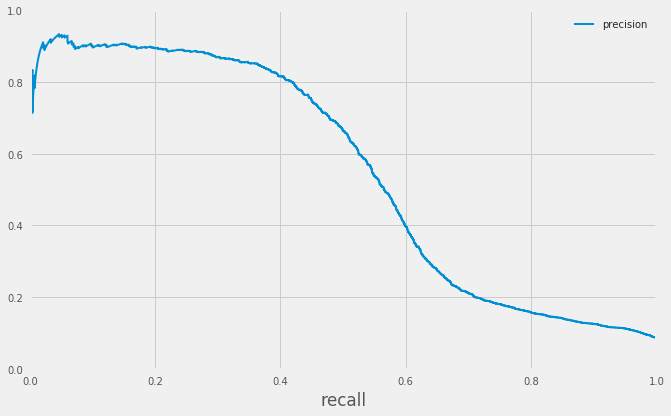

In [202]:
curves_df = pandas.DataFrame(curves['football'])
curves_df.plot(x='recall', y='precision')

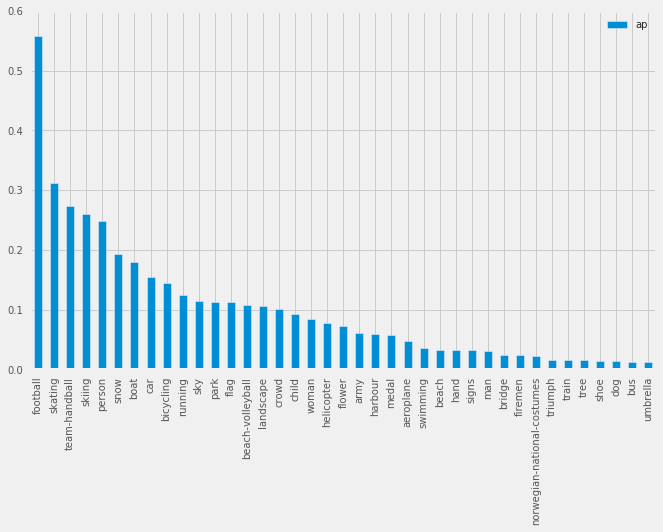

In [203]:
data = {
    'size': [len(test_data[label]) for label in labels],
    'ap': [ap[label] for label in labels],
}
ap_df = pandas.DataFrame(data, index=list(labels))
ap_df.sort_values('ap', ascending=False).plot(kind='bar', y='ap')

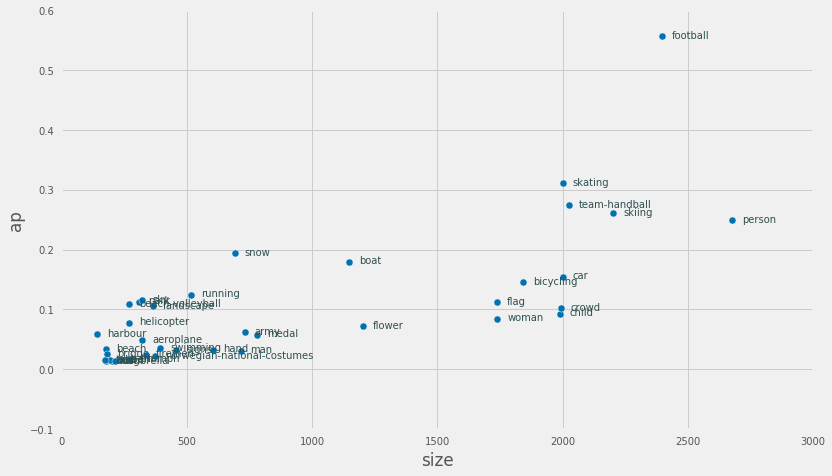

In [210]:
ax = ap_df.plot('size', 'ap', kind='scatter', s=50, figsize=(12,7))
def annotate_df(row):
    ax.annotate(row.name, (row['size'], row['ap']),
                xytext=(10,-2), 
                textcoords='offset points',
                size=10,
                color='darkslategrey')

_ = ap_df.apply(annotate_df, axis=1) # with labels

In [ ]:
show_top_labels(scores, random.choice(list(test_data['car'])))

In [99]:
show_top_pictures(scores, 'car', num=10)

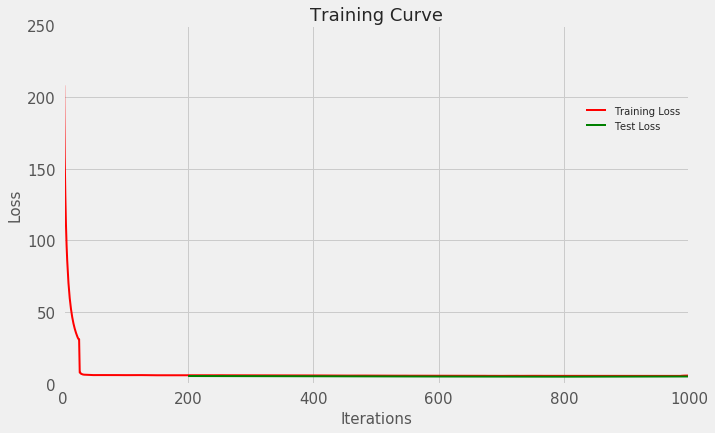

In [221]:
show_training_curve(log_path)

# Sigmoid loss function, no augmentation, raw dataset, SGD solver

In [227]:
sgd_snapshot = 1000
sgd_transformer = Transformer(shape=[227,227])
sgd_net_name = "ft_sigmoid_noaug_allpics_sgd"
sgd_net_dir = pjoin(NETS_DIR, sgd_net_name)
sgd_data_dir = pjoin(sgd_net_dir, 'data')
sgd_log_path = pjoin(sgd_net_dir, 'train.log')
sgd_labels = np.load(pjoin(sgd_data_dir, 'labels.np'))
with open(pjoin(sgd_data_dir, 'test_raw.pickle')) as test_file:
    sgd_test_data = pickle.load(test_file)
    assert set(sgd_test_data.keys()) == set(sgd_labels)

In [224]:
%time sgd_scores, sgd_curves, sgd_ap = get_metrics("ft_sigmoid_noaug_allpics_sgd", sgd_transformer, sgd_snapshot)

Set batch_size to 256
Going to process 110 batches
Batch 0 finised
Batch 50 finised
Batch 100 finised
Scores are dumped to /storage/ntb/nets/ft_sigmoid_noaug_allpics_sgd/data/scores_1000.np
CPU times: user 55min 40s, sys: 3min 37s, total: 59min 17s
Wall time: 48min 42s


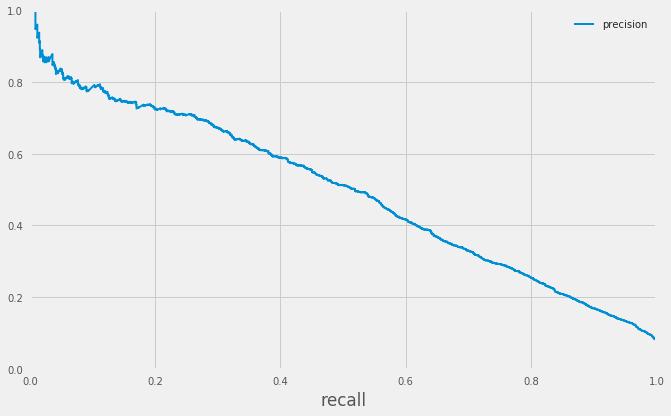

In [268]:
sgd_curves_df = pandas.DataFrame(sgd_curves['crowd'])
sgd_curves_df.plot(x='recall', y='precision')

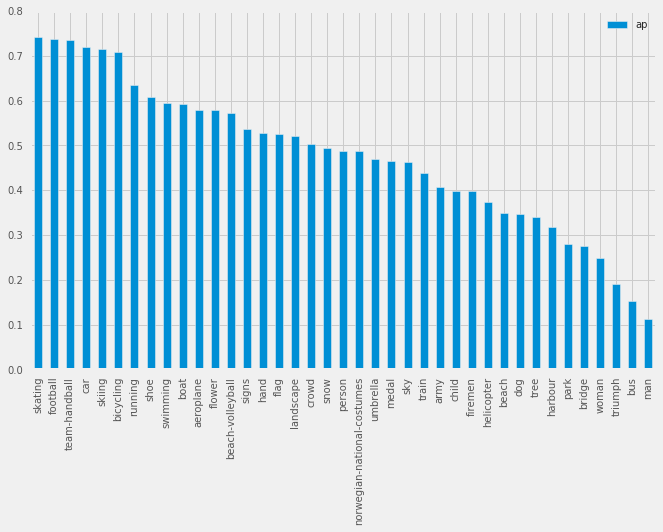

In [232]:
sgd_data = {
    'size': [len(sgd_test_data[label]) for label in sgd_labels],
    'ap': [sgd_ap[label] for label in sgd_labels],
}
sgd_ap_df = pandas.DataFrame(sgd_data, index=list(sgd_labels))
sgd_ap_df.sort_values('ap', ascending=False).plot(kind='bar', y='ap')

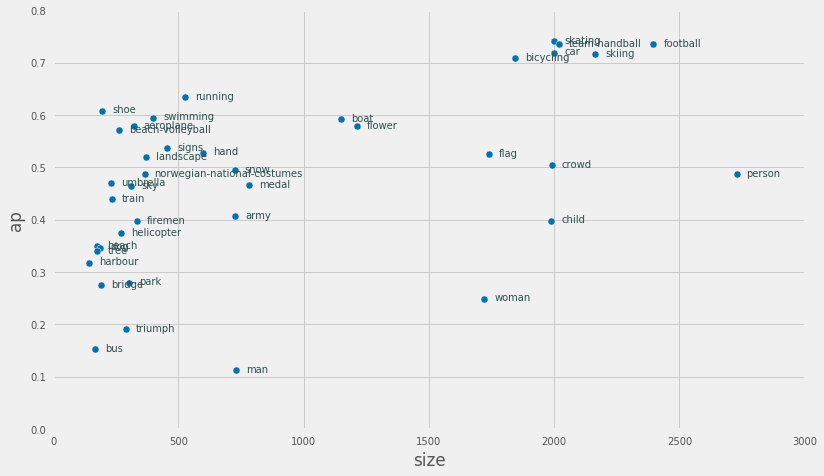

In [233]:
sgd_ax = sgd_ap_df.plot('size', 'ap', kind='scatter', s=50, figsize=(12,7))
def annotate_df(row):
    sgd_ax.annotate(row.name, (row['size'], row['ap']),
                xytext=(10,-2), 
                textcoords='offset points',
                size=10,
                color='darkslategrey')

_ = sgd_ap_df.apply(annotate_df, axis=1) # with labels

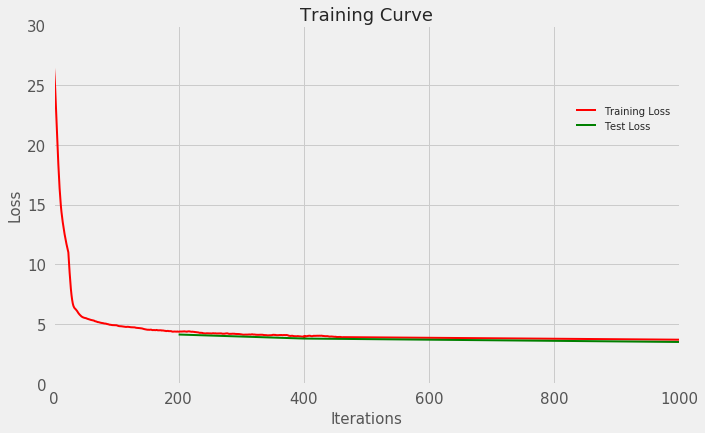

In [253]:
show_training_curve(sgd_log_path)

In [264]:
show_top_pictures(sgd_scores, 'triumph')

# Comparison

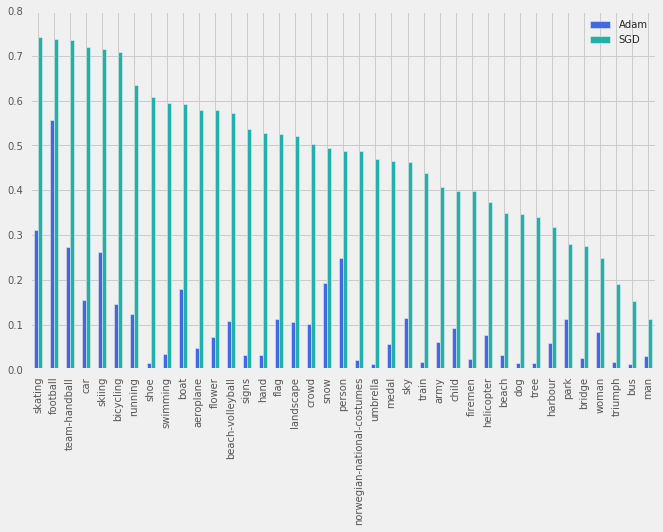

In [318]:
compare_ap_df = pandas.concat([ap_df, sgd_ap_df], keys=['Adam', 'SGD'])
compare_ap_df.unstack(level=0).sort_values([('ap', 'SGD')], ascending=False).plot(kind='bar', y='ap', color=['royalblue','lightseagreen', ])